In [1]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import PIL
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
#Size of our input images
SIZE = 128

#############################################################################
#Define generators for training, validation and also anomaly data.

batch_size = 64
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    'Datasets/Casting/train_ok/',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )

validation_generator = datagen.flow_from_directory(
    'Datasets/Casting/test_ok/',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )

anomaly_generator = datagen.flow_from_directory(
    'Datasets/Casting/train_def/',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )

Found 2875 images belonging to 1 classes.
Found 262 images belonging to 1 classes.
Found 3758 images belonging to 1 classes.


In [3]:
#Define the autoencoder.
#Try to make the bottleneck layer size as small as possible to make it easy for
#density calculations and also picking appropriate thresholds.
#Encoder
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))


#Decoder
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()

c:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,659 (205.70 KB)

 Trainable params: 52,659 (205.70 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
filepath = "modelv1v3.keras"

# fit the model
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
history = model.fit(
        train_generator,
        steps_per_epoch= 500 // batch_size,
        epochs=100,
        validation_data=validation_generator,
        validation_steps=75 // batch_size,
        shuffle = True,
        callbacks=callbacks_list)

Epoch 1/100


c:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0638 - mse: 0.0638
Epoch 1: loss improved from inf to 0.06167, saving model to modelv1v3.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - loss: 0.0635 - mse: 0.0635 - val_loss: 0.0562 - val_mse: 0.0562
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0559 - mse: 0.0559
Epoch 2: loss improved from 0.06167 to 0.05483, saving model to modelv1v3.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - loss: 0.0558 - mse: 0.0558 - val_loss: 0.0518 - val_mse: 0.0518
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0499 - mse: 0.0499
Epoch 3: loss improved from 0.05483 to 0.04776, saving model to modelv1v3.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - loss: 0.0496 - mse: 0.0496 - val_loss: 0.0433 - val_mse: 0.0433
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0408 - mse: 0.0408
Epoch 4: loss improved from 0.04776 to 0.03823, saving model to modelv1v3.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - loss: 0.0405 - mse: 0.0405 - val_loss: 0

c:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3/7 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0265 - mse: 0.0265
Epoch 7: loss improved from 0.02854 to 0.01950, saving model to modelv1v3.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 602ms/step - loss: 0.0225 - mse: 0.0262 - val_loss: 0.0262 - val_mse: 0.0262
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0257 - mse: 0.0257
Epoch 8: loss did not improve from 0.01950
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - loss: 0.0256 - mse: 0.0256 - val_loss: 0.0240 - val_mse: 0.0240
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0228 - mse: 0.0228
Epoch 9: loss did not improve from 0.01950
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 0.0228 - mse: 0.0228 - val_loss: 0.0217 - val_mse: 0.0217
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0216 - mse: 0.0216
Epoch 10: loss did not improve from 0.01950
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 0.0215 - mse: 0.0215 - val_loss: 0.0199 - val_mse: 0.0199
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0199 - mse: 0.0199
E

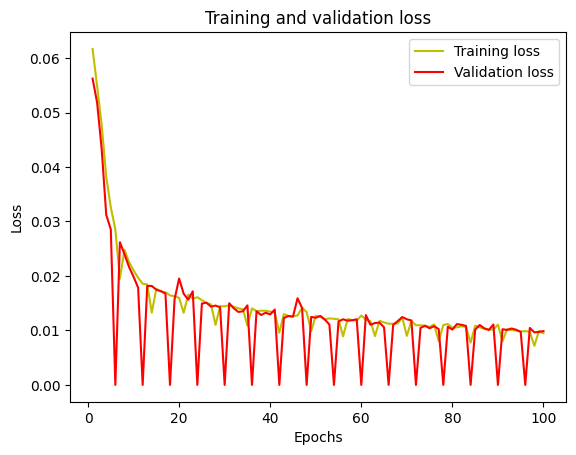

In [5]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [6]:
# Get all batches generated by the datagen and pick a batch for prediction
#Just to test the model.
data_batch = []  #Capture all training batches as a numpy array
img_num = 0
while img_num <= train_generator.batch_index:   #gets each generated batch of size batch_size
    data = next(train_generator)
    data_batch.append(data[0])
    img_num = img_num + 1

predicted = model.predict(data_batch[0])  #Predict on the first batch of images

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step


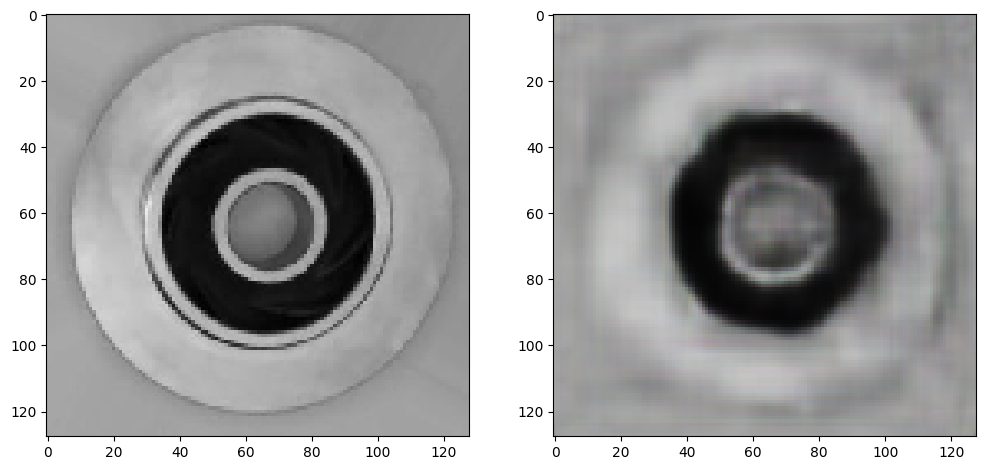

In [7]:
#Sanity check, view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(data_batch[0][image_number])
plt.subplot(122)
plt.imshow(predicted[image_number])
plt.show()

In [8]:
#Let us examine the reconstruction error between our validation data (good/normal images)
# and the anomaly images
validation_error = model.evaluate(validation_generator)
anomaly_error = model.evaluate(anomaly_generator)

print("Recon. error for the validation (normal) data is: ", validation_error)
print("Recon. error for the anomaly data is: ", anomaly_error)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 352ms/step - loss: 0.0098 - mse: 0.0098
59/59 ━━━━━━━━━━━━━━━━━━━━ 30s 503ms/step - loss: 0.0113 - mse: 0.0113
Recon. error for the validation (normal) data is:  [0.00966056901961565, 0.009826086461544037]
Recon. error for the anomaly data is:  [0.011247457936406136, 0.011250556446611881]


In [9]:
encoder_model = Sequential()
encoder_model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3)))
encoder_model.layers[-1].set_weights(model.layers[0].get_weights())

encoder_model.add(MaxPooling2D((2, 2), padding='same'))

encoder_model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
encoder_model.layers[-1].set_weights(model.layers[2].get_weights())

encoder_model.add(MaxPooling2D((2, 2), padding='same'))

encoder_model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
encoder_model.layers[-1].set_weights(model.layers[4].get_weights())

encoder_model.add(MaxPooling2D((2, 2), padding='same'))

encoder_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,880 (97.19 KB)

 Trainable params: 24,880 (97.19 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Calculate KDE using sklearn
from sklearn.neighbors import KernelDensity

#Get encoded output of input images = Latent space
encoded_images = encoder_model.predict(train_generator)

# Flatten the encoder output because KDE from sklearn takes 1D vectors as input
encoder_output_shape = encoder_model.output_shape #Here, we have 16x16x16
out_vector_shape = encoder_output_shape[1]*encoder_output_shape[2]*encoder_output_shape[3]

encoded_images_vector = [np.reshape(img, (out_vector_shape)) for img in encoded_images]

#Fit KDE to the image latent data
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_vector)

#Calculate density and reconstruction error to find their means values for
#good and anomaly images.
#We use these mean and sigma to set thresholds.
def calc_density_and_recon_error(batch_images):

    density_list=[]
    recon_error_list=[]
    for im in range(0, batch_images.shape[0]-1):

        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        encoded_img = encoder_model.predict([[img]]) # Create a compressed version of the image using the encoder
        encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] # Flatten the compressed image
        density = kde.score_samples(encoded_img)[0] # get a density score for the new image
        reconstruction = model.predict([[img]])
        reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]
        density_list.append(density)
        recon_error_list.append(reconstruction_error)

    average_density = np.mean(np.array(density_list))
    stdev_density = np.std(np.array(density_list))

    average_recon_error = np.mean(np.array(recon_error_list))
    stdev_recon_error = np.std(np.array(recon_error_list))

    return average_density, stdev_density, average_recon_error, stdev_recon_error

45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 197ms/step


In [11]:
train_batch = next(train_generator)[0]
anomaly_batch = next(anomaly_generator)[0]

uninfected_values = calc_density_and_recon_error(train_batch)
anomaly_values = calc_density_and_recon_error(anomaly_batch)

print(uninfected_values)
print(anomaly_values)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step - loss: 0.0149 - mse: 0.0149
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0140 - mse: 0.0140
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0158 - mse: 0.0158
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0147 - mse: 0.0147
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0124 - mse: 0.0124
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0103 - mse: 0.0103
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0169 - mse: 0.0

In [16]:
#Get average and std dev. of density and recon. error for uninfected and anomaly (parasited) images.
#For this let us generate a batch of images for each.
good = 0
bad = 0

train_batch = next(train_generator)[0]
anomaly_batch = next(anomaly_generator)[0]

uninfected_values = calc_density_and_recon_error(train_batch)
anomaly_values = calc_density_and_recon_error(anomaly_batch)


#Now, input unknown images and sort as Good or Anomaly
def check_anomaly(img_path):
    global good, bad
    density_threshold = 2690 #2623.6147759607406 #2815 #Set this value based on the above exercise
    reconstruction_error_threshold = 0.015 #0.24 # Set this value based on the above exercise
    img  = Image.open(img_path)
    img = np.array(img.resize((128,128), PIL.Image.LANCZOS))
    # plt.imshow(img)
    img = img / 255.
    img = img[np.newaxis, :,:,:]
    encoded_img = encoder_model.predict([[img]])
    encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img]
    density = kde.score_samples(encoded_img)[0]

    reconstruction = model.predict([[img]])
    reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]

    if density < density_threshold or reconstruction_error > reconstruction_error_threshold:
        bad =  bad + 1

    else:
        good = good + 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0083 - mse: 0.0083
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0109 - mse: 0.0109
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0143 - mse: 0.0143
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0193 - mse: 0.0193
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0105 - mse: 0.0105
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0193 - mse: 0.0193
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0111 - mse: 0.0111

In [13]:
#Load a couple of test images and verify whether they are reported as anomalies.
import glob
Defect_testpath = glob.glob('Datasets/casting_data/casting_data/test/def_test/*')
Ok_testpath = glob.glob('Datasets/casting_data/casting_data/test/ok_test/*')

In [130]:
#Anomaly image verification
num= random.randint(0, len(Defect_testpath)-1)
check_anomaly(Defect_testpath[num])
print("The image is an anomaly; ", bad)
print("The image is NOT an anomaly; ", good)
good = 0
bad = 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0082 - mse: 0.0082
The image is an anomaly;  1


In [17]:
for i in range(len(Defect_testpath)):
  check_anomaly(Defect_testpath[i])
print("The image IS an anomaly; ", bad)
print("The image is not an anomaly; ", good)
good = 0
bad = 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0086 - mse: 0.0086
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0089 - mse: 0.0089
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0190 - mse: 0.0190
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0099 - mse: 0.0099
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0150 - mse: 0.0150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0224 - mse: 0.0224
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0109 - mse:

In [113]:
#Good/normal image verification
num=random.randint(0,len(Ok_testpath)-1)
check_anomaly(Ok_testpath[num])
good = 0
bad = 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0128 - mse: 0.0128
The image is NOT an anomaly;  56


In [18]:
for i in range(len(Ok_testpath)):
  check_anomaly(Ok_testpath[i])
print("The image is an anomaly; ", bad)
print("The image is NOT an anomaly; ", good)
good = 0
bad = 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0091 - mse: 0.0091
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0088 - mse: 0.0088
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0121 - mse: 0.0121
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0183 - mse: 0.0183
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0128 - mse: 0.0128
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0164 - mse: 0.0164
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0094 - mse: 0.0094